In [1]:
%pip install fuzzywuzzy

DEPRECATION: keras-complex 0.2.3 has a non-standard dependency specifier tensorflow>="2.0.0". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of keras-complex or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install python-Levenshtein

DEPRECATION: keras-complex 0.2.3 has a non-standard dependency specifier tensorflow>="2.0.0". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of keras-complex or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [74]:
import matplotlib.pyplot as plt

In [144]:
import requests
from bs4 import BeautifulSoup
import numpy as np


paronyms = []


# взятие паронимов с открытого ресурса
home_url = 'https://ru-paronym.ru'
ru_alphabet = [chr(i) for i in range(ord('А'), ord('А') + 32)]
no_words = ['Ё', 'Й', 'Щ', 'Ъ', 'Ы', 'Ь']

# Создаем множество всех слов из датасета паронимов
all_words = set()

for letter in ru_alphabet:
    if letter in no_words:
        continue
    url = home_url + '/' + letter
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    arr = soup.find_all('a', href=True)[2:-27]  # Откидываем первые 2 и последние 27 элемента, которые есть на каждой странице
    for elem in arr:
        webpage = home_url + elem['href']
        words = (elem.string).split(' — ')
        paronyms.append([words[0] + '_' + words[1], 1])  # пары слов - паронимы
        paronyms.append([words[1] + '_' + words[0], 1])  # пара в обратном порядке
        all_words.update((words[0], words[1])) # Создаем множество всех слов из датасета паронимов

In [163]:
# база данных с кортежами с меткой (1) - паронимы
print(paronyms[:20])

[['абонемент_абонент', 1], ['абонент_абонемент', 1], ['абстрактность_абстракция', 1], ['абстракция_абстрактность', 1], ['авантюрин_авантюрист', 1], ['авантюрист_авантюрин', 1], ['автобиографический_автобиографичный', 1], ['автобиографичный_автобиографический', 1], ['автоматический_автоматичный', 1], ['автоматичный_автоматический', 1], ['автономия_автономность', 1], ['автономность_автономия', 1], ['авторитарный_авторитетный', 1], ['авторитетный_авторитарный', 1], ['адресант_адресат', 1], ['адресат_адресант', 1], ['азарт_азартность', 1], ['азартность_азарт', 1], ['академический_академичный', 1], ['академичный_академический', 1]]


In [146]:
import random

# создание пар слов не паронимов путем перемешивания уже имеющихся слов
def generate_non_paronyms(paronyms, seed = None):

    non_paronyms = []

    if seed:
      random.seed(seed)

    # Случайные пары из множества всех слов
    for _ in range(len(paronyms)):
        word1, word2 = random.choices(list(all_words), k=2)
        if (word1 + ' ' + word2, 1) not in paronyms:
          non_paronyms.append([word1 + '_' + word2, 0])  # Метка 0, так как это непаронимы

    return non_paronyms

non_paronyms = generate_non_paronyms(paronyms, 42)


In [148]:
dataset_par = paronyms + non_paronyms
random.shuffle(dataset_par) # перемешивание датасета на всякий случай
print(dataset_par[:10])

[['памятливый_памятный', 1], ['обоснование_основание', 1], ['вспоминать_поминать', 1], ['цветовой_фантастичный', 0], ['схоластический_могильник', 0], ['крючкотворский_крючкотворный', 1], ['сладостный_сладкий', 1], ['демонстративный_демонстрационный', 1], ['покорный_покорливый', 1], ['гнуткий_гнутый', 1]]


In [149]:
import pandas as pd

data = pd.DataFrame(dataset_par, columns=['word_pair', 'label'])
data

,word_pair,label
0,памятливый_памятный,1
1,обоснование_основание,1
2,вспоминать_поминать,1
3,цветовой_фантастичный,0
4,схоластический_могильник,0
...,...,...
3511,оболванить_обезлюдить,0
3512,советник_советчик,1
3513,пометка_обрывок,0
3514,штатский_русский,0


First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [150]:
#all unique characters go here
tokens = set()
for name in data['word_pair']:
    tokens.update(set(name))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  40


## Convert characters to integers
Torch is built for crunching numbers, not strings. To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [151]:
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('=') # <PAD>

token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [152]:
def to_matrix(
    words, max_len=None, pad=token_to_id['='], dtype='int32', batch_first=True
    ):
    """Casts a list of words into transformer-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    max_len += 2
    words_ix = np.zeros([len(words), max_len], dtype) + pad
    words_ix[:, 0] = token_to_id['<'] # <SOS>

    for i in range(len(words)):
        line_ix = [token_to_id[c] for c in words[i]]
        words_ix[i, 1:(len(line_ix) + 1)] = line_ix[:]
        words_ix[i, len(line_ix) + 1] = token_to_id['>'] # <EOS>

        
    if not batch_first: # convert [batch, time] into [time, batch]
        words_ix = np.transpose(words_ix)

    return words_ix

In [153]:
print(data['word_pair'][:2])
print('\n', to_matrix(data['word_pair'][:2]))

0      памятливый_памятный
1    обоснование_основание
Name: word_pair, dtype: object

 [[40  3 14 21 22  2  0 11 19 35 20 27  3 14 21 22  2 24 35 20 41 42 42]
 [40 18 15 18  6 24 18 19 14 24 11 16 27 18  6 24 18 19 14 24 11 16 41]]


In [154]:
words_matrix = to_matrix(data['word_pair'])

for i in range(len(data['word_pair'])):
    data['word_pair'].iloc[i] = words_matrix[i]

/var/folders/xw/04yvk1hx1tg55kxcyvtbggcm0000gn/T/ipykernel_12041/3642515764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_pair'].iloc[i] = words_matrix[i]


In [155]:
import torch
from torch.utils.data import Dataset, DataLoader

class WordPairDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word_pair, label = self.data.iloc[idx]

        return torch.tensor(word_pair, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Создание экземпляра датасета
train_dataset = WordPairDataset(data[:3000])
test_dataset = WordPairDataset(data[3001:])

# Создание DataLoader
batch_size = 32
data_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_test = DataLoader(test_dataset, batch_size=batch_size,)

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim

class SelfAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, num_heads=8):
        super(SelfAttentionModel, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.self_attention_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_size, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(1, 0, 2)  # Change the dimensions for Multihead Attention
        for layer in self.self_attention_layers:
            embedded, _ = layer(embedded, embedded, embedded)
        attn_output = embedded.permute(1, 0, 2)  # Reshape to the original dimensions
        attn_output = torch.mean(attn_output, dim=1)  # Take the mean across all attention heads
        output = self.fc(attn_output)
        return output

input_size = 7000
hidden_size = 128
num_layers = 2
num_classes = 2

model = SelfAttentionModel(input_size, hidden_size, num_classes, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [157]:
num_epochs = 15
loss_arr = []

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in data_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss_arr.append(np.mean(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_train)  # средняя ошибка на эпохе
    loss_arr.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/15], Loss: 0.6486303429020212
Epoch [2/15], Loss: 0.43171474876555993
Epoch [3/15], Loss: 0.3323831445676215
Epoch [4/15], Loss: 0.25592914933061345
Epoch [5/15], Loss: 0.21687053350058008
Epoch [6/15], Loss: 0.19694332017543467
Epoch [7/15], Loss: 0.18461781987880774
Epoch [8/15], Loss: 0.15838731555862628
Epoch [9/15], Loss: 0.16012322649042657
Epoch [10/15], Loss: 0.1517768032214743
Epoch [11/15], Loss: 0.13713592004546143
Epoch [12/15], Loss: 0.12695358370609106
Epoch [13/15], Loss: 0.12533825345614807
Epoch [14/15], Loss: 0.1094309259602364
Epoch [15/15], Loss: 0.1124776038440301


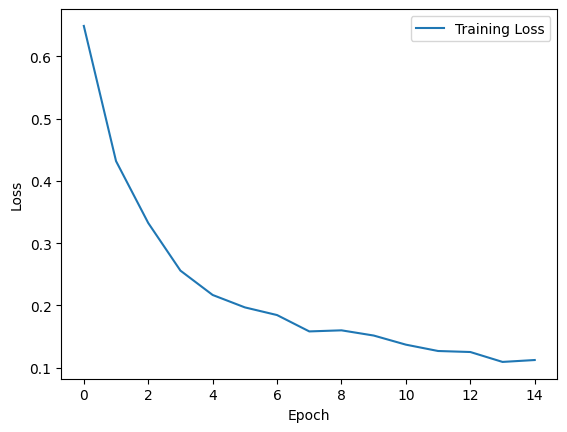

In [158]:
plt.plot(loss_arr, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [159]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():  # Отключение вычисления градиентов
    for inputs, labels in data_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Получение индекса класса с максимальной вероятностью

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [160]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels, average='binary')
precision = precision_score(true_labels, predicted_labels, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-score: {2 * precision * recall / (precision + recall)}')

Accuracy: 0.912621359223301
Recall: 0.9498069498069498
Precision: 0.8848920863309353
F1-score: 0.9162011173184357


In [161]:
from fuzzywuzzy import fuzz
import Levenshtein

def levenshtein_distance(dataset): # вычисление расстояния левенштейна и сходства слов
    distances = []

    for (word1, word2), _ in dataset:
        lev_dist = Levenshtein.distance(word1, word2)
        lev_ratio = fuzz.ratio(word1, word2)
        distances.append((word1, word2, lev_dist, lev_ratio))

    return distances

In [162]:
lev = levenshtein_distance(dataset_par)
lev

ValueError: too many values to unpack (expected 2)